In [1]:
%pip install -q --no-warn-conflicts malariagen_data
%pip install -q --no-warn-conflicts petl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB

In [2]:
import allel
import malariagen_data
import pandas as pd
import numpy as np
import petl as ptl

In [3]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.legend import Legend
from matplotlib.patches import Patch
import matplotlib_venn as venn
import seaborn as sns
import plotly.express as px
import re

In [4]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
# make dir
results_dir = "drive/MyDrive"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [5]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release_master_us_central1/", pre=True)

## Let's check the the sample set
df_samples=ag3.sample_metadata(sample_sets='3.11', sample_query='country=="Burkina Faso"')
sets = list(df_samples.sample_set.unique())

In [6]:
df_geneset = ag3.geneset().set_index("ID")
#df_geneset

In [7]:
#df_geneset.columns

In [8]:
#df_geneset.query('type =="chromosome"')

In [9]:
## chrom
chrom = {
    '2L':'2L:1-49364325',
    '2R':'2R:1-61545105',
    '3L':'3L:1-41963435',
    '3R':'3R:1-53200684',
    'X':'X:1-24393108'
}

xlim_2L = (1,49364325)
xlim_2R = (1,61545105)
xlim_2L = (1,41963435)
xlim_2R = (1,53200684)

## read tables

In [10]:
## read CNV tables
cnv_hmm = pd.read_csv('drive/MyDrive/sanger_analyses/resistance/CNV/data/cnv_df_hmm.csv').drop(['Unnamed: 0'],axis=1)
#cnv_hmm.head()

/tmp/ipython-input-2946344628.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  cnv_hmm = pd.read_csv('drive/MyDrive/sanger_analyses/resistance/CNV/data/cnv_df_hmm.csv').drop(['Unnamed: 0'],axis=1)


In [11]:
## Basic manipulation
#
gene_dict = np.load('drive/MyDrive/sanger_analyses/resistance/CNV/data/gene_dict.npy', allow_pickle='TRUE').item()

###
sp_map,loc_map = {}, {}
for i in df_samples.sample_id.unique():
  sp_map[i] = df_samples.query(f'sample_id == "{i}"').aim_species.unique()[0]
  loc_map[i] = df_samples.query(f'sample_id == "{i}"').location.unique()[0]

###
species = {
    "gambiae":"Agam",
    "coluzzii":"Acol",
    "arabiensis":"Aara",
    "intermediate_gambiae_coluzzii":"Hybrid",
    "intermediate_gambcolu_arabiensis":"Hybrid"
}

##
#select_gene = coe_id_list+gste_id_lit+cyp_id_list
select_gene = gene_dict['coe']+gene_dict['gste']+gene_dict['cyp']
cnv_select = cnv_hmm.query('gene_id in @select_gene')
cnv_select['pos'] = [np.mean([x,y]) for x,y in zip(cnv_select['gene_start'],cnv_select['gene_end']) if x!=0 and y!=0]
#cnv_select

gene_map = {}
for gene in select_gene:
    if gene in gene_dict['coe']:
        gene_map[gene] = 'COE'
    elif gene in gene_dict['gste']:
        gene_map[gene] = 'GSTE'
    elif gene in gene_dict['cyp']:
        gene_map[gene] = 'CYP'
    else:
        pass

###
cnv_select['taxon'] = cnv_select.sample_id.map(sp_map)
cnv_select['aim_species'] = cnv_select.taxon.map(species)
cnv_select['location'] = cnv_select.sample_id.map(loc_map)
cnv_select['gene_map'] = cnv_select.gene_id.map(gene_map)

/tmp/ipython-input-1107890593.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnv_select['pos'] = [np.mean([x,y]) for x,y in zip(cnv_select['gene_start'],cnv_select['gene_end']) if x!=0 and y!=0]
/tmp/ipython-input-1107890593.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnv_select['taxon'] = cnv_select.sample_id.map(sp_map)
/tmp/ipython-input-1107890593.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [12]:
### colors
marker={'Agam':'o','Acol':'v','Aara':'D', 'Hybrid':'*'}
color = {'Agam':'#069AF3', 'Acol':'#F97306', 'Aara':'#9A0EEA',
         'Hybrid':'#FFD700'}
g_marker = {'COE':'o', 'GSTE':'v', 'CYP':'X'}
g_color = {'COE':'#069AF3', 'GSTE':'#F97306', 'CYP':'#9A0EEA'}

([], [])

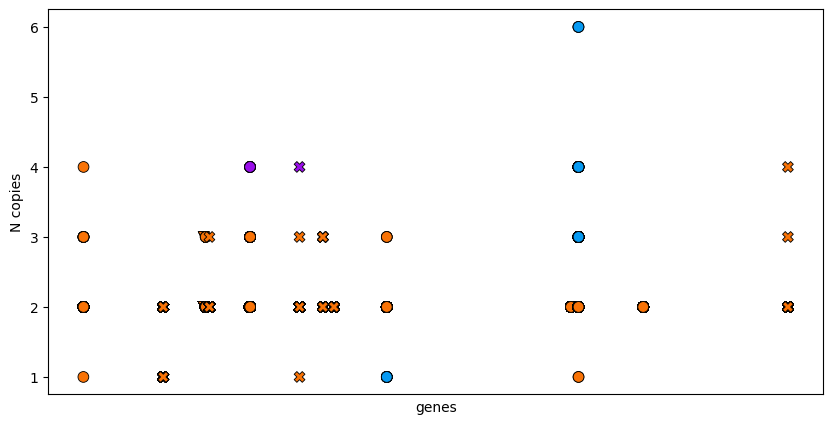

In [13]:
fig = plt.figure(figsize=(10, 5))
cnv_2L = cnv_select.query('gene_contig=="2L"')
fig = sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2L, markers=g_marker,style='gene_map',
                      palette=color, s=60, edgecolor='black', legend=False)
fig.set(xlabel = "genes", ylabel = "N copies")
plt.xticks(ticks=[], labels=[])

## functions for plotting

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


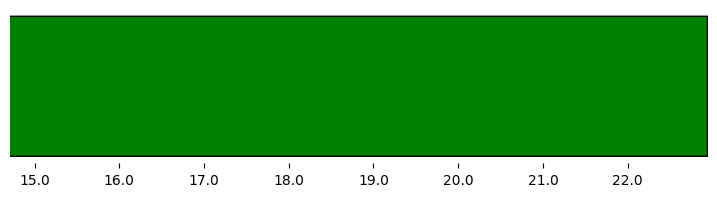

In [14]:
# pos
pos = cnv_select.pos.to_list()

## funct
def fig_seq (xlim1=pos, xy=(0,0), wh=(pos[-1],0.05),boxstyle=("Round, pad=0.1"),
             facecolor="green", edgecolor=None,ax=None, xlab=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(9, 2))
  sns.despine(ax=ax, left=True, bottom=True)
  patch = mpl.patches.FancyBboxPatch((xy[0],xy[1]),wh[0],wh[1], boxstyle=boxstyle,
                                     facecolor=facecolor, edgecolor=edgecolor)
  ax.add_patch(patch)
  if xlab:
    ax.set_xlabel(f'{xlab}')

  if xlim1:
    xlim=(list(xlim1)[0], list(xlim1)[-1])
    ax.set_xlim(*xlim)
    ax.set_yticks([])
    ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
    ax.autoscale(axis='y', tight=False)
fig_seq()
#plt.axvspan(15240572, 15242864, color='magenta', alpha=0.2, ls='--', lw=0.2)

## Plotting

In [15]:
## Pos and CNV subset
## 2L
cnv_2L = cnv_select.query('gene_contig=="2L"')
pos_2L = cnv_2L.pos.to_list()

## 2R
cnv_2R = cnv_select.query('gene_contig=="2R"')
pos_2R = cnv_2R.pos.to_list()

## 3L
cnv_3L = cnv_select.query('gene_contig=="3L"')
pos_3L = cnv_3L.pos.to_list()

## 3R
cnv_3R = cnv_select.query('gene_contig=="3R"')
pos_3R = cnv_3R.pos.to_list()

## X
cnv_X = cnv_select.query('gene_contig=="X"')
pos_X = cnv_X.pos.to_list()

In [16]:
cnv_2L.columns

Index(['genes', 'samples', 'gene_contig', 'gene_start', 'gene_end',
       'gene_windows', 'gene_name', 'gene_strand', 'gene_description',
       'CN_mode', 'CN_mode_count', 'sample_id', 'sample_coverage_variance',
       'sample_is_high_variance', 'gene_id', 'pos', 'taxon', 'aim_species',
       'location', 'gene_map'],
      dtype='object')

In [17]:
#cnv_2L['CN_mode_count']#.describe()

In [18]:
#cnv_2L['CN_mode']

## 2RL

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


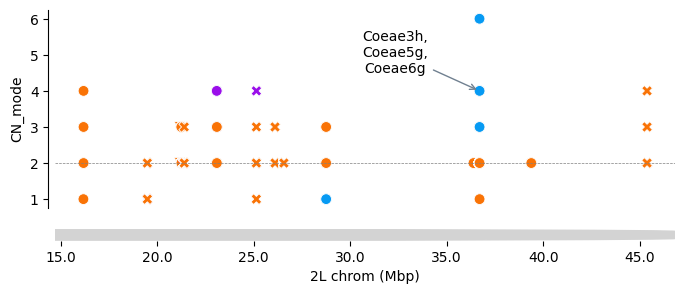

In [19]:
fig = plt.figure(figsize=(8,3))
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2L, markers=g_marker,style='gene_map',
                palette=color, s=60, legend=False, ax=ax0)
ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Coeae3h,\nCoeae5g,\nCoeae6g', xy=(np.mean([37288762, 37295490]), 4), xytext=(np.mean([32485262, 32487080]), 4.5), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_2L,xy=(0,0), wh=(pos_2L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2L chrom (Mbp)')


/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


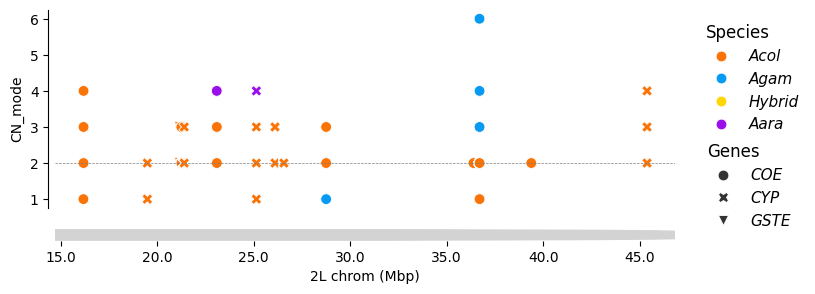

In [20]:
fig = plt.figure(figsize=(8,3))
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2L,
                markers=g_marker,style='gene_map',
                palette=color, s=60, legend=True, ax=ax0)
ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

handles, labels = ax0.get_legend_handles_labels()
kl1,kl2 = len(color.keys()), len(labels)
lek = list(marker.keys())
ax0.legend(handles[1:1+kl1], labels[1:1+kl1],ncol=1,title ='Species',alignment='left',
         loc='upper right', bbox_to_anchor=(1.222,1),title_fontproperties={'size':12, 'weight':'normal'},
         frameon=False,prop={'size':11, 'style': 'italic'})
aleg = Legend(ax0, handles[2+kl1:kl2], labels[2+kl1:kl2], title='Genes',
             alignment='left',bbox_to_anchor=(1.03,0.4), prop={'size':11, 'style': 'italic'},
             title_fontproperties={'size':12, 'weight':'normal'},frameon=False)
fig.add_artist(aleg)

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_2L,xy=(0,0), wh=(pos_2L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2L chrom (Mbp)')

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


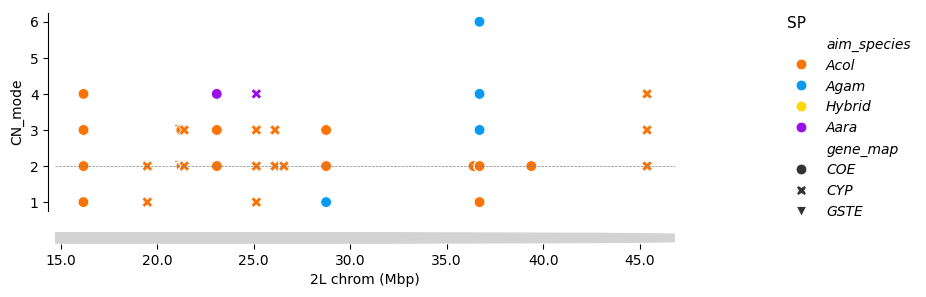

In [21]:
fig = plt.figure(figsize=(8,3))
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2L,
                markers=g_marker,style='gene_map',
                palette=color, s=60, legend=True, ax=ax0)
ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')



handles, labels = ax0.get_legend_handles_labels()
kl1,kl2 = len(color.keys()), len(labels)
lek = list(marker.keys())
ax0.legend(handles, labels,ncol=1,title ='SP',alignment='left',
         loc='upper right', bbox_to_anchor=(1.4,1.05),title_fontproperties={'size':11, 'weight':'normal'},
         frameon=False,prop={'size':10, 'style': 'italic'})

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_2L,xy=(0,0), wh=(pos_2L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2L chrom (Mbp)')

In [22]:
labels[2+kl1:kl2],handles[1:1+kl1]

(['COE', 'CYP', 'GSTE'],
  <matplotlib.lines.Line2D at 0x7c7b53444da0>])

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


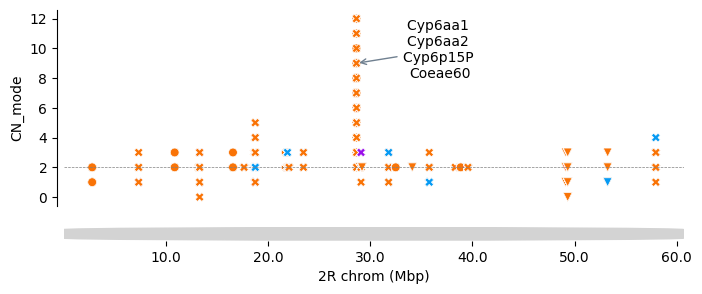

In [23]:
fig = plt.figure(figsize=(8,3))
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(5,0.35))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2R, markers=g_marker,style='gene_map',
                palette=color, s=40, legend=False, ax=ax0)
ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Cyp6aa1 \nCyp6aa2 \nCyp6p15P \nCoeae60', xy=(np.mean([28485262, 28487080]), 9), xytext=(np.mean([37485262, 37487080]), 8), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_2R,xy=(0,0), wh=(pos_2R[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2R chrom (Mbp)')

## 3RL

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


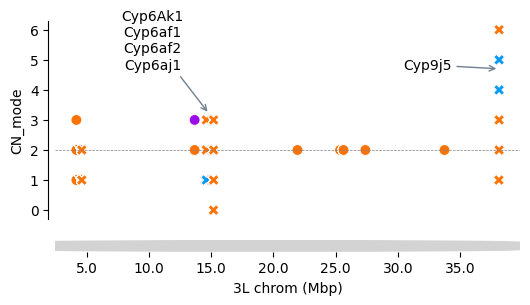

In [24]:
fig = plt.figure(figsize=(6,3))
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_3L, markers=g_marker,style='gene_map',
                palette=color, s=60, legend=False, ax=ax0)
ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Cyp9j5', xy=(np.mean([39838568, 39838568]), 4.7), xytext=(np.mean([33485262, 33487080]), 4.7), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

plt.annotate('Cyp6Ak1\nCyp6af1\nCyp6af2\nCyp6aj1', xy=(np.mean([13839175, 14602874]), 3.2), xytext=(np.mean([8839175, 9602874]), 4.7), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_3L,xy=(0,0), wh=(pos_3L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='3L chrom (Mbp)')

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


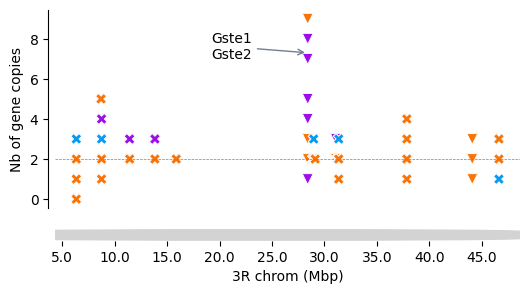

In [25]:
fig = plt.figure(figsize=(6,3))
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_3R, markers=g_marker,style='gene_map',
                palette=color, s=60, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('Nb of gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Gste1\nGste2', xy=(np.mean([28597652, 28598640]), 7.3), xytext=(np.mean([20597652, 20598640]), 7), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_3R,xy=(0,0), wh=(pos_3R[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='3R chrom (Mbp)')

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


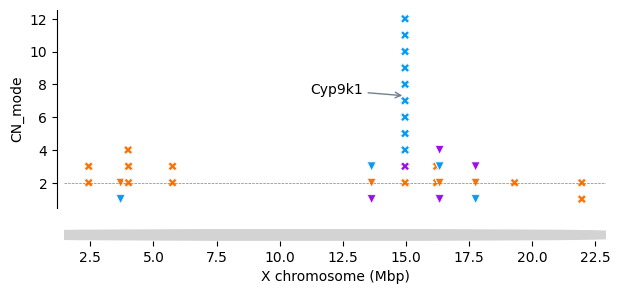

In [26]:
fig = plt.figure(figsize=(7,3))
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_X, markers=g_marker,style='gene_map',
                palette=color, s=40, legend=False, ax=ax0)

ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Cyp9k1', xy=(np.mean([15240572, 15242864]), 7.3), xytext=(np.mean([12240572, 12242864]), 7.4), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center')

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_X,xy=(0,0), wh=(pos_X[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='X chromosome (Mbp)')

## multiple plots

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-34738

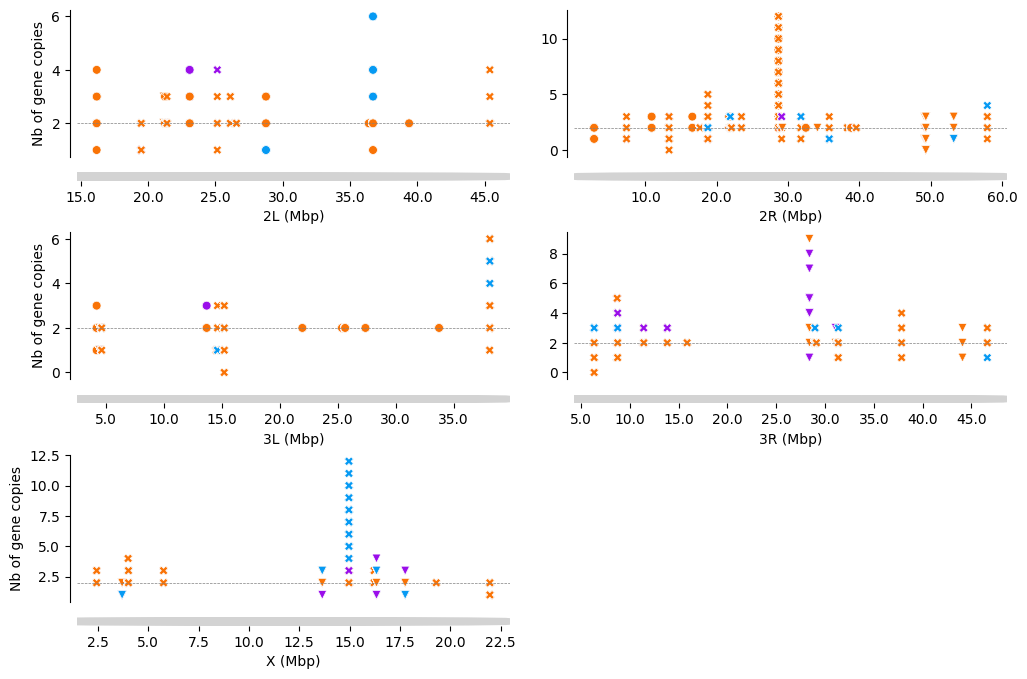

In [27]:
fig = plt.figure(figsize=(12,8))
gs0 = gridspec.GridSpec(3, 2, wspace=0.15, hspace=0.3)

#2L
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2L, markers=g_marker,style='gene_map',
                palette=color, s=40, legend=False, ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('Nb of gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_2L,xy=(0,0), wh=(pos_2L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2L (Mbp)')

##2R
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2R, markers=g_marker,style='gene_map',
                palette=color, s=40, legend=False, ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_2R,xy=(0,0), wh=(pos_2R[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2R (Mbp)')

##3L
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[2],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_3L, markers=g_marker,style='gene_map',
                palette=color, s=40, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('Nb of gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_3L,xy=(0,0), wh=(pos_3L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='3L (Mbp)')

## 3R
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[3],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_3R, markers=g_marker,style='gene_map',
                palette=color, s=40, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_3R,xy=(0,0), wh=(pos_3R[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='3R (Mbp)')

## X
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[4],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_X, markers=g_marker,style='gene_map',
                palette=color, s=40, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('Nb of gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_X,xy=(0,0), wh=(pos_X[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='X (Mbp)')



fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/CNV/grouped_graph1.png',dpi=300, bbox_inches='tight')

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-34738

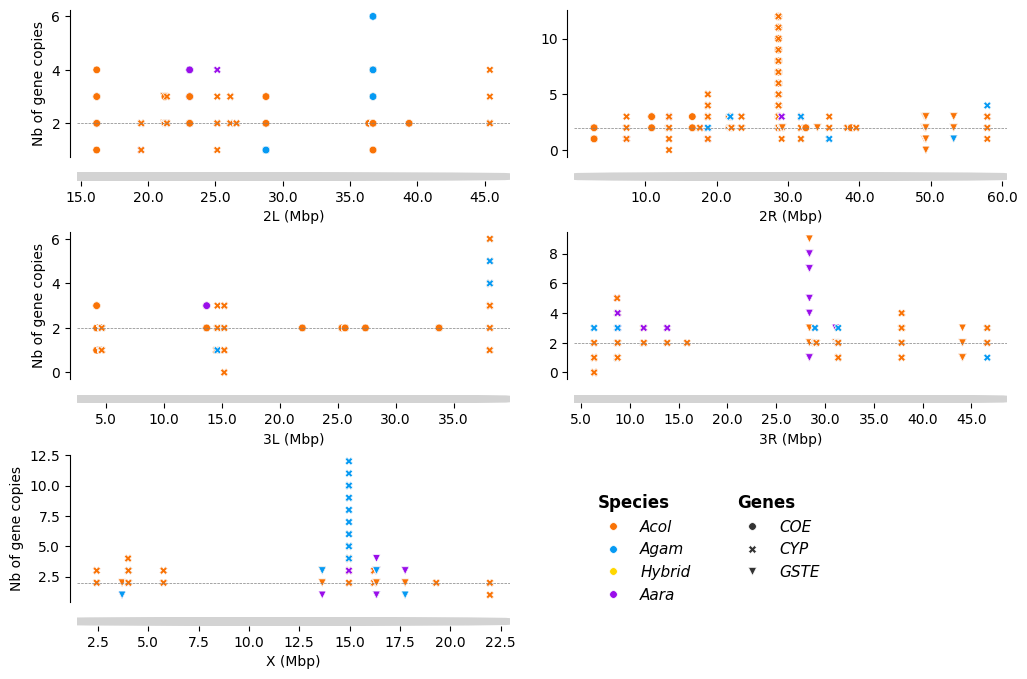

In [28]:
fig = plt.figure(figsize=(12,8))
gs0 = gridspec.GridSpec(3, 2, wspace=0.15, hspace=0.3)

#2L
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2L, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=False, ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('Nb of gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_2L,xy=(0,0), wh=(pos_2L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2L (Mbp)')

##2R
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1],height_ratios=(6,0.35))
ax01 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax01, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2R, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=True, ax=ax01)
ax01.set_xlabel('')
ax01.set_ylabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_2R,xy=(0,0), wh=(pos_2R[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2R (Mbp)')

##3L
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[2],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_3L, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('Nb of gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_3L,xy=(0,0), wh=(pos_3L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='3L (Mbp)')

## 3R
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[3],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_3R, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_3R,xy=(0,0), wh=(pos_3R[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='3R (Mbp)')

## X
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[4],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_X, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('Nb of gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_X,xy=(0,0), wh=(pos_X[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='X (Mbp)')

handles, labels = ax01.get_legend_handles_labels()
kl1,kl2 = len(color.keys()), len(labels)
lek = list(marker.keys())
ax01.legend(handles[1:1+kl1], labels[1:1+kl1],ncol=1,title ='Species',alignment='left',
         loc='upper right', bbox_to_anchor=(0.3,-2.2),title_fontproperties={'size':12, 'weight':'bold'},
         frameon=False,prop={'size':11, 'style': 'italic'})
aleg = Legend(ax01, handles[2+kl1:kl2], labels[2+kl1:kl2], title='Genes',
             alignment='left',bbox_to_anchor=(0.6,-2.2), prop={'size':11, 'style': 'italic'},
             title_fontproperties={'size':12, 'weight':'bold'},frameon=False)
fig.add_artist(aleg)

fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/CNV/grouped_graph12.png',dpi=300, bbox_inches='tight')

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])
/tmp/ipython-input-34738

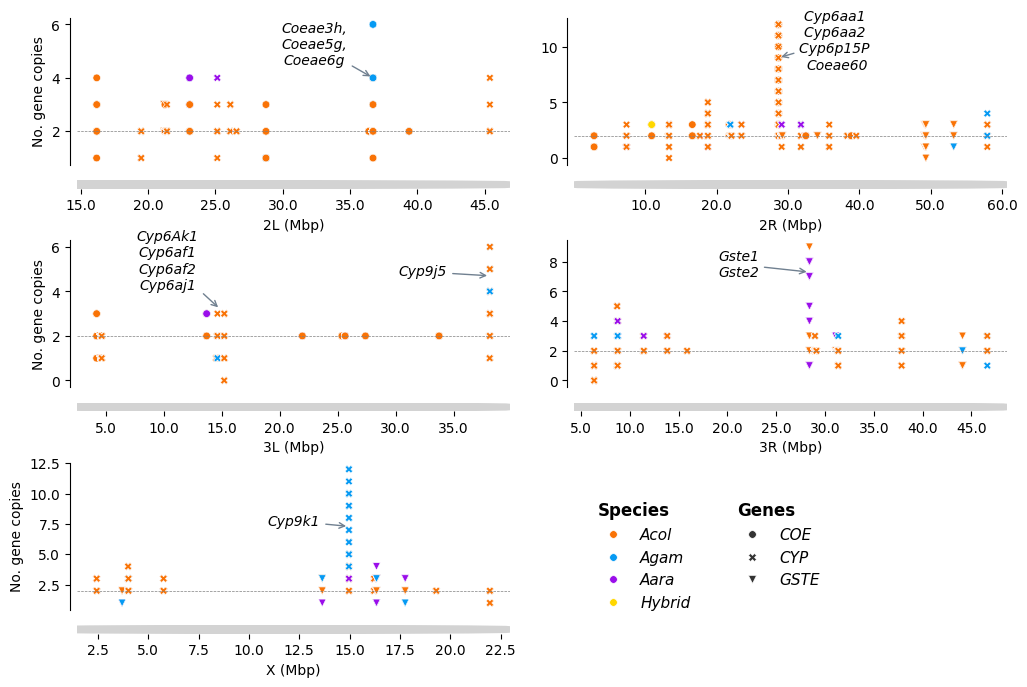

In [67]:
fig = plt.figure(figsize=(12,8))
gs0 = gridspec.GridSpec(3, 2, wspace=0.15, hspace=0.3)

#2L
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2L, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=False, ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('No. gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')


plt.annotate('Coeae3h,\nCoeae5g,\nCoeae6g', xy=(np.mean([37288762, 37295490]), 4), xytext=(np.mean([32485262, 32487080]), 4.5), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center',fontstyle='italic')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_2L,xy=(0,0), wh=(pos_2L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2L (Mbp)')

##2R
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1],height_ratios=(6,0.35))
ax01 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax01, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_2R, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=True, ax=ax01)
ax01.set_xlabel('')
ax01.set_ylabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Cyp6aa1 \nCyp6aa2 \nCyp6p15P \nCoeae60', xy=(np.mean([28485262, 28487080]), 9), xytext=(np.mean([37485262, 37487080]), 8), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center',fontstyle='italic')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_2R,xy=(0,0), wh=(pos_2R[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='2R (Mbp)')

##3L
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[2],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_3L, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('No. gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Cyp9j5', xy=(np.mean([39838568, 39838568]), 4.7), xytext=(np.mean([33485262, 33487080]), 4.7), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center',fontstyle='italic')

plt.annotate('Cyp6Ak1\nCyp6af1\nCyp6af2\nCyp6aj1', xy=(np.mean([13839175, 14602874]), 3.2), xytext=(np.mean([8839175, 9602874]), 4.1), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center',fontstyle='italic')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_3L,xy=(0,0), wh=(pos_3L[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='3L (Mbp)')

## 3R
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[3],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_3R, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Gste1\nGste2', xy=(np.mean([28597652, 28598640]), 7.3), xytext=(np.mean([20597652, 20598640]), 7), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center',fontstyle='italic')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_3R,xy=(0,0), wh=(pos_3R[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='3R (Mbp)')

## X
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[4],height_ratios=(6,0.35))
ax0 = fig.add_subplot(gs00[0, 0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos', y='CN_mode', hue='aim_species', data=cnv_X, markers=g_marker,style='gene_map',
                palette=color, s=30, legend=False, ax=ax0)

ax0.set_xlabel('')
ax0.set_ylabel('No. gene copies')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

plt.annotate('Cyp9k1', xy=(np.mean([15240572, 15242864]), 7.3), xytext=(np.mean([12240572, 12242864]), 7.4), color='k',fontsize=10,
             arrowprops=dict(arrowstyle="->", color='slategrey'), ha='center',fontstyle='italic')

ax1 = fig.add_subplot(gs00[1, 0])
fig_seq(pos_X,xy=(0,0), wh=(pos_X[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray', xlab='X (Mbp)')

handles, labels = ax01.get_legend_handles_labels()
kl1,kl2 = len(color.keys()), len(labels)
lek = list(marker.keys())
ax01.legend(handles[1:1+kl1], labels[1:1+kl1],ncol=1,title ='Species',alignment='left',
         loc='upper right', bbox_to_anchor=(0.3,-2.2),title_fontproperties={'size':12, 'weight':'bold'},
         frameon=False,prop={'size':11, 'style': 'italic'})
aleg = Legend(ax01, handles[2+kl1:kl2], labels[2+kl1:kl2], title='Genes',
             alignment='left',bbox_to_anchor=(0.6,-2.2), prop={'size':11, 'style': 'italic'},
             title_fontproperties={'size':12, 'weight':'bold'},frameon=False)
fig.add_artist(aleg)

fig.savefig(fname='drive/MyDrive/sanger_analyses/resistance/CNV/grouped_graph123.png',dpi=300, bbox_inches='tight')

##  Stats

In [30]:
## reshape table
df_cnv = cnv_select.groupby(['gene_contig','gene_start','gene_end', 'gene_id',	'gene_name','gene_map','aim_species'])['CN_mode'].value_counts().reset_index()
#df_cnv = cnv_select.groupby(['gene_contig','gene_start','gene_end', 'gene_id',	'gene_name','gene_map'])['CN_mode'].value_counts().reset_index()
df_cnv.head()

,gene_contig,gene_start,gene_end,gene_id,gene_name,gene_map,aim_species,CN_mode,count
0,2L,14709900,14711640,AGAP005370,COEBE4C,COE,Aara,2,52
1,2L,14709900,14711640,AGAP005370,COEBE4C,COE,Acol,2,345
2,2L,14709900,14711640,AGAP005370,COEBE4C,COE,Acol,1,1
3,2L,14709900,14711640,AGAP005370,COEBE4C,COE,Acol,3,1
4,2L,14709900,14711640,AGAP005370,COEBE4C,COE,Agam,2,92


In [31]:
#Total number of gene with CNV
print('Total gene with CNV: ', len(list(df_cnv.query('CN_mode !=2').gene_name.unique())))
print('Total gene with CNV del: ', len(list(df_cnv.query('CN_mode <2').gene_name.unique())))
print('Total gene with CNV amp: ', len(list(df_cnv.query('CN_mode >2').gene_name.unique())))

#by chrom
T1 = df_cnv.query('CN_mode !=2').groupby('gene_contig')['gene_name'].nunique()
T2 = df_cnv.query('CN_mode <2').groupby('gene_contig')['gene_name'].nunique()
T3 = df_cnv.query('CN_mode >2').groupby('gene_contig')['gene_name'].nunique()
df_count = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count

Total gene with CNV:  142
Total gene with CNV del:  63
Total gene with CNV amp:  122


,gene_contig,CNV,CNV_Del,CNV_Amp
0,2L,26,9,22
1,2R,50,23,44
2,3L,15,9,10
3,3R,37,16,35
4,X,14,6,11


In [32]:
## Overall CNVs
df_cnv_overall = df_cnv.query('CN_mode !=2').groupby(['aim_species','gene_contig','gene_start','gene_end', 'gene_id','gene_name','gene_map','CN_mode'])['gene_name'].nunique()
df_cnv_overall = df_cnv_overall.rename('gene_name1').reset_index()
df_cnv_overall = df_cnv_overall.drop('gene_name1', axis=1)
df_cnv_overall.to_excel('drive/MyDrive/sanger_analyses/resistance/CNV/data/df_cnv_overall.xlsx')
df_cnv_overall.to_csv('drive/MyDrive/sanger_analyses/resistance/CNV/data/df_cnv_overall.csv')

In [33]:
df_cnv_overall.gene_contig.unique()

array(['2L', '2R', '3L', '3R', 'X'], dtype=object)

In [34]:
#COE genes
coe_cnv = df_cnv.query('gene_map=="COE"')

#Total number of COE gene with CNV
print('Total gene with CNV: ', len(list(coe_cnv.query('CN_mode !=2').gene_name.unique())))
print('Total gene with CNV del: ', len(list(coe_cnv.query('CN_mode <2').gene_name.unique())))
print('Total gene with CNV amp: ', len(list(coe_cnv.query('CN_mode >2').gene_name.unique())))

#by chrom
T1 = coe_cnv.query('CN_mode !=2').groupby('gene_contig')['gene_name'].nunique()
T2 = coe_cnv.query('CN_mode <2').groupby('gene_contig')['gene_name'].nunique()
T3 = coe_cnv.query('CN_mode >2').groupby('gene_contig')['gene_name'].nunique()
df_count_coe = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count_coe

Total gene with CNV:  25
Total gene with CNV del:  6
Total gene with CNV amp:  24


,gene_contig,CNV,CNV_Del,CNV_Amp
0,2L,16,4,16
1,2R,5,1,4
2,3L,4,1,4


In [35]:
## COE by species
T1 = coe_cnv.query('CN_mode !=2').groupby('aim_species')['gene_name'].nunique()
T2 = coe_cnv.query('CN_mode <2').groupby('aim_species')['gene_name'].nunique()
T3 = coe_cnv.query('CN_mode >2').groupby('aim_species')['gene_name'].nunique()
df_count_coe_species1 = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count_coe_species1.fillna(0)

,aim_species,CNV,CNV_Del,CNV_Amp
0,Aara,11,1.0,10
1,Acol,24,6.0,23
2,Agam,15,2.0,13
3,Hybrid,6,0.0,6


In [36]:
## COE by species
T1 = coe_cnv.query('CN_mode !=2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
T2 = coe_cnv.query('CN_mode <2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
T3 = coe_cnv.query('CN_mode >2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
df_count_coe_species = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count_coe_species.fillna(0)

,aim_species,gene_contig,CNV,CNV_Del,CNV_Amp
0,Aara,2L,8,1.0,7
1,Aara,2R,2,0.0,2
2,Aara,3L,1,0.0,1
3,Acol,2L,15,4.0,15
4,Acol,2R,5,1.0,4
5,Acol,3L,4,1.0,4
6,Agam,2L,10,1.0,9
7,Agam,2R,3,1.0,2
8,Agam,3L,2,0.0,2
9,Hybrid,2L,5,0.0,5


In [37]:
### Min max
max = coe_cnv.CN_mode.max()
min = coe_cnv.CN_mode.min()
coe_cnv.query(f'CN_mode in [{max},{min}]')

,gene_contig,gene_start,gene_end,gene_id,gene_name,gene_map,aim_species,CN_mode,count
2,2L,14709900,14711640,AGAP005370,COEBE4C,COE,Acol,1,1
129,2L,28548433,28550748,AGAP006228,COEAE2F,COE,Aara,1,1
131,2L,28548433,28550748,AGAP006228,COEAE2F,COE,Acol,1,3
134,2L,28548433,28550748,AGAP006228,COEAE2F,COE,Agam,1,5
183,2L,37292956,37295490,AGAP006727,COEAE6G,COE,Acol,1,1
195,2L,37296161,37298202,AGAP006728,COEAE7G,COE,Acol,1,1
214,2R,54602,60297,AGAP001101,COEBE2O,COE,Acol,1,4
216,2R,54602,60297,AGAP001101,COEBE2O,COE,Agam,1,1
453,2R,28485262,28487080,AGAP002863,COEAE6O,COE,Acol,12,8
677,3L,2482177,2486705,AGAP010390,COE12O,COE,Acol,1,2


In [38]:
#GSTE genes
gste_cnv = df_cnv.query('gene_map=="GSTE"')

#Total number of COE gene with CNV
print('Total gene with CNV: ', len(list(gste_cnv.query('CN_mode !=2').gene_name.unique())))
print('Total gene with CNV del: ', len(list(gste_cnv.query('CN_mode <2').gene_name.unique())))
print('Total gene with CNV amp: ', len(list(gste_cnv.query('CN_mode >2').gene_name.unique())))

#by chrom
T1 = gste_cnv.query('CN_mode !=2').groupby('gene_contig')['gene_name'].nunique()
T2 = gste_cnv.query('CN_mode <2').groupby('gene_contig')['gene_name'].nunique()
T3 = gste_cnv.query('CN_mode >2').groupby('gene_contig')['gene_name'].nunique()
df_count_gste = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index().fillna(0)
df_count_gste

Total gene with CNV:  26
Total gene with CNV del:  16
Total gene with CNV amp:  19


,gene_contig,CNV,CNV_Del,CNV_Amp
0,2L,1,0.0,1.0
1,2R,9,6.0,5.0
2,3L,1,1.0,0.0
3,3R,10,4.0,10.0
4,X,5,5.0,3.0


In [39]:
### Min max
max = gste_cnv.CN_mode.max()
min = gste_cnv.CN_mode.min()
gste_cnv.query(f'CN_mode in [{max},{min}]')

,gene_contig,gene_start,gene_end,gene_id,gene_name,gene_map,aim_species,CN_mode,count
628,2R,51217666,51218384,AGAP004173,GSTD5,GSTE,Acol,0,5
631,2R,51217666,51218384,AGAP004173,GSTD5,GSTE,Agam,0,1
1009,3R,28597652,28598640,AGAP009194,GSTE2,GSTE,Acol,9,1


In [40]:
## GSTE by species
T1 = gste_cnv.query('CN_mode !=2').groupby('aim_species')['gene_name'].nunique()
T2 = gste_cnv.query('CN_mode <2').groupby('aim_species')['gene_name'].nunique()
T3 = gste_cnv.query('CN_mode >2').groupby('aim_species')['gene_name'].nunique()
df_count_gste_species1 = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count_gste_species1.fillna(0)

,aim_species,CNV,CNV_Del,CNV_Amp
0,Aara,12,8,5
1,Acol,25,15,15
2,Agam,18,9,10
3,Hybrid,4,1,3


In [41]:
## GSTE by species
T1 = gste_cnv.query('CN_mode !=2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
T2 = gste_cnv.query('CN_mode <2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
T3 = gste_cnv.query('CN_mode >2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
df_count_gste_species = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count_gste_species.fillna(0)

,aim_species,gene_contig,CNV,CNV_Del,CNV_Amp
0,Aara,2R,1,1.0,0.0
1,Aara,3L,1,1.0,0.0
2,Aara,3R,6,3.0,3.0
3,Aara,X,4,3.0,2.0
4,Acol,2L,1,0.0,1.0
5,Acol,2R,9,6.0,5.0
6,Acol,3L,1,1.0,0.0
7,Acol,3R,9,4.0,7.0
8,Acol,X,5,4.0,2.0
9,Agam,2L,1,0.0,1.0


In [42]:
#CYP genes
cyp_cnv = df_cnv.query('gene_map=="CYP"')

#Total number of COE gene with CNV
print('Total gene with CNV: ', len(list(cyp_cnv.query('CN_mode !=2').gene_name.unique())))
print('Total gene with CNV del: ', len(list(cyp_cnv.query('CN_mode <2').gene_name.unique())))
print('Total gene with CNV amp: ', len(list(cyp_cnv.query('CN_mode >2').gene_name.unique())))

#by chrom
T1 = cyp_cnv.query('CN_mode !=2').groupby('gene_contig')['gene_name'].nunique()
T2 = cyp_cnv.query('CN_mode <2').groupby('gene_contig')['gene_name'].nunique()
T3 = cyp_cnv.query('CN_mode >2').groupby('gene_contig')['gene_name'].nunique()
df_count_cyp = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count_cyp

Total gene with CNV:  91
Total gene with CNV del:  41
Total gene with CNV amp:  79


,gene_contig,CNV,CNV_Del,CNV_Amp
0,2L,9,5,5
1,2R,36,16,35
2,3L,10,7,6
3,3R,27,12,25
4,X,9,1,8


In [43]:
## CYP by species
T1 = cyp_cnv.query('CN_mode !=2').groupby('aim_species')['gene_name'].nunique()
T2 = cyp_cnv.query('CN_mode <2').groupby('aim_species')['gene_name'].nunique()
T3 = cyp_cnv.query('CN_mode >2').groupby('aim_species')['gene_name'].nunique()
df_count_cyp_species1 = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count_cyp_species1.fillna(0)

,aim_species,CNV,CNV_Del,CNV_Amp
0,Aara,66,19,52
1,Acol,85,35,68
2,Agam,60,31,42
3,Hybrid,15,6,9


In [44]:
## CYP by species
T1 = cyp_cnv.query('CN_mode !=2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
T2 = cyp_cnv.query('CN_mode <2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
T3 = cyp_cnv.query('CN_mode >2').groupby(['aim_species','gene_contig'])['gene_name'].nunique()
df_count_cyp = pd.DataFrame({'CNV':T1, 'CNV_Del':T2, 'CNV_Amp':T3}).reset_index()
df_count_cyp.fillna(0)

,aim_species,gene_contig,CNV,CNV_Del,CNV_Amp
0,Aara,2L,5,3.0,2.0
1,Aara,2R,27,7.0,24.0
2,Aara,3L,6,3.0,3.0
3,Aara,3R,20,5.0,16.0
4,Aara,X,8,1.0,7.0
5,Acol,2L,8,4.0,5.0
6,Acol,2R,33,15.0,30.0
7,Acol,3L,10,7.0,6.0
8,Acol,3R,25,8.0,19.0
9,Acol,X,9,1.0,8.0


In [45]:
## Min max CYP
max = cyp_cnv.CN_mode.max()
min = cyp_cnv.CN_mode.min()
cyp_cnv.query(f'CN_mode in [{max},{min}]')

,gene_contig,gene_start,gene_end,gene_id,gene_name,gene_map,aim_species,CN_mode,count
253,2R,11617151,11618933,AGAP013305,CYP4H25,CYP,Acol,0,1
425,2R,28480576,28482637,AGAP002862,CYP6AA1,CYP,Acol,12,4
440,2R,28483301,28484921,AGAP013128,CYP6AA2,CYP,Acol,12,5
468,2R,28487640,28489092,AGAP002864,CYP6P15P,CYP,Acol,12,8
726,3L,14600396,14602874,AGAP011028,CYP6AF1,CYP,Acol,0,2
820,3R,4324183,4326568,AGAP008020,CYP12F2,CYP,Aara,0,1
823,3R,4324183,4326568,AGAP008020,CYP12F2,CYP,Acol,0,45
1178,X,15240572,15242864,AGAP000818,CYP9K1,CYP,Agam,12,2


In [46]:
#len(list(df_cnv.query('CN_mode !=2 and gene_contig == "2L"').gene_name.unique()))

In [47]:
#len(list(df_cnv.query('CN_mode !=2 and gene_contig == "2R"').gene_name.unique()))

In [48]:
#Total number of gene with CNV
#print('Total gene with CNV: ', df_cnv.query('CN_mode !=2').shape[0])
#print('Total gene with CNV del: ', df_cnv.query('CN_mode <2').shape[0])
#print('Total gene with CNV amp: ', df_cnv.query('CN_mode >2').shape[0])

# by chrom
#T1 = df_cnv.query('CN_mode !=2').groupby('gene_contig').count()
#T2 = df_cnv.query('CN_mode <2').groupby('gene_contig').count()
#T3 = df_cnv.query('CN_mode >2').groupby('gene_contig').count()
#df_count1 = pd.DataFrame({'CNV':T1.CN_mode, 'CNV_Del':T2.CN_mode, 'CNV_Amp':T3.CN_mode}).reset_index()
#df_count1

In [49]:
#COE genes
#coe_cnv = df_cnv.query('gene_map=="COE"')

#Total number of COE gene with CNV
#print('Total gene with CNV: ', coe_cnv.query('CN_mode !=2').shape[0])
#print('Total gene with CNV del: ', coe_cnv.query('CN_mode <2').shape[0])
#print('Total gene with CNV amp: ', coe_cnv.query('CN_mode >2').shape[0])

# by chrom
#T1 = coe_cnv.query('CN_mode !=2').groupby('gene_contig').count()
#T2 = coe_cnv.query('CN_mode <2').groupby('gene_contig').count()
#T3 = coe_cnv.query('CN_mode >2').groupby('gene_contig').count()
#df_count_coe = pd.DataFrame({'CNV':T1.CN_mode, 'CNV_Del':T2.CN_mode, 'CNV_Amp':T3.CN_mode}).reset_index()
#df_count_coe

In [50]:
#len(list(coe_cnv.query('CN_mode >2').gene_name.unique()))

In [51]:
#GSTE genes
#gste_cnv = df_cnv.query('gene_map=="GSTE"')

#Total number of COE gene with CNV
#print('Total gene with CNV: ', gste_cnv.query('CN_mode !=2').shape[0])
#print('Total gene with CNV del: ', gste_cnv.query('CN_mode <2').shape[0])
#print('Total gene with CNV amp: ', gste_cnv.query('CN_mode >2').shape[0])

# by chrom
#T1 = gste_cnv.query('CN_mode !=2').groupby('gene_contig').count()
#T2 = gste_cnv.query('CN_mode <2').groupby('gene_contig').count()
#T3 = gste_cnv.query('CN_mode >2').groupby('gene_contig').count()
#df_count_gste = pd.DataFrame({'CNV':T1.CN_mode, 'CNV_Del':T2.CN_mode, 'CNV_Amp':T3.CN_mode}).reset_index().fillna(0)
#df_count_gste

In [52]:
#CYP genes
#cyp_cnv = df_cnv.query('gene_map=="CYP"')

#Total number of COE gene with CNV
#print('Total gene with CNV: ', cyp_cnv.query('CN_mode !=2').shape[0])
#print('Total gene with CNV del: ', cyp_cnv.query('CN_mode <2').shape[0])
#print('Total gene with CNV amp: ', cyp_cnv.query('CN_mode >2').shape[0])

# by chrom
#T1 = cyp_cnv.query('CN_mode !=2').groupby('gene_contig').count()
#T2 = cyp_cnv.query('CN_mode <2').groupby('gene_contig').count()
#T3 = cyp_cnv.query('CN_mode >2').groupby('gene_contig').count()
#df_count_cyp = pd.DataFrame({'CNV':T1.CN_mode, 'CNV_Del':T2.CN_mode, 'CNV_Amp':T3.CN_mode}).reset_index().fillna(0)
#df_count_cyp

In [53]:
#coe_cnv = cnv_select.query('gene_map=="COE"')
#cyp_cnv = cnv_select.query('gene_map=="CYP"')
#gste_cnv = cnv_select.query('gene_map=="GSTE"')

In [54]:
#coe_cnv.CN_mode.value_counts()

### RL

In [55]:
#chrom

In [56]:
## 2RL
cnv_2L = cnv_2L.sort_values(by='pos',ascending=True)
cnv_2R = cnv_2R.sort_values(by='pos',ascending=True)
pos_2L = sorted(pos_2L)
pos_2R = sorted(pos_2R)

cnv_2L['pos_2RL'] = [i for i in pos_2L]
cnv_2R['pos_2RL'] = [i+49364325 for i in pos_2R]

cnv_2RL = pd.concat([cnv_2L,cnv_2R])
pos_2RL = cnv_2RL.pos_2RL.to_list()
#cnv_2RL

## 3RL
cnv_3L = cnv_3L.sort_values(by='pos',ascending=True)
cnv_3R = cnv_3R.sort_values(by='pos',ascending=True)
pos_3L = sorted(pos_3L)
pos_3R = sorted(pos_3R)

cnv_3L['pos_3RL'] = [i for i in pos_3L]
cnv_3R['pos_3RL'] = [i+41963435 for i in pos_3R]

cnv_3RL = pd.concat([cnv_3L,cnv_3R])
pos_3RL = cnv_3RL.pos_3RL.to_list()
#cnv_3RL

## clu
lab_2RL = ['2L', '2R']
pos12R = cnv_2R.pos_2RL.to_list()
vspans_2RL = [(pos_2L[0],pos_2L[-1]),(pos12R[0],pos12R[-1])]

lab_3RL = ['3L', '3R']
pos13R = cnv_3R.pos_3RL.to_list()
vspans_3RL = [(pos_3L[0],pos_3L[-1]),(pos13R[0],pos13R[-1])]



/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


([], [])

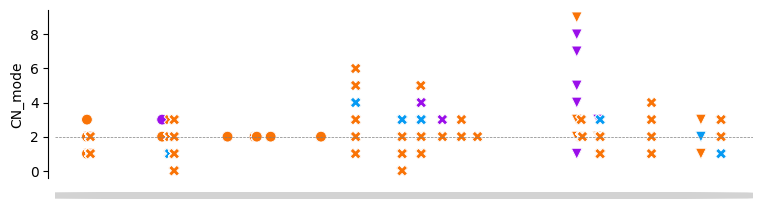

In [57]:
fig = plt.figure(figsize=(9,3))
gs = plt.GridSpec(nrows=3, ncols=1, height_ratios=(6,0.25,1))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos_3RL', y='CN_mode', hue='aim_species', data=cnv_3RL, markers=g_marker,style='gene_map',
                palette=color, s=60, legend=False, ax=ax0)

ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_3RL,xy=(0,0), wh=(pos_3RL[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray')
plt.xticks(ticks=[], labels=[])


/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


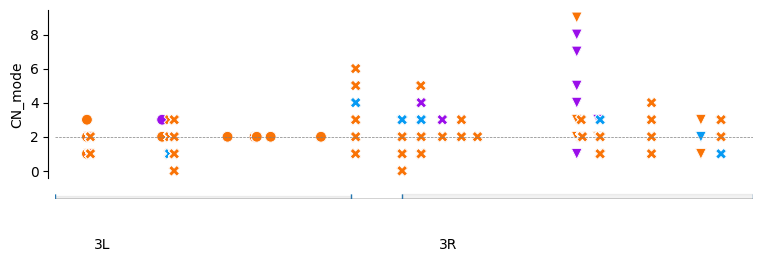

In [58]:
fig = plt.figure(figsize=(9,3))
gs = plt.GridSpec(nrows=3, ncols=1, height_ratios=(6,0.25,1))
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos_3RL', y='CN_mode', hue='aim_species', data=cnv_3RL, markers=g_marker,style='gene_map',
                palette=color, s=60, legend=False, ax=ax0)

ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_3RL,xy=(0,0), wh=(pos_3RL[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray')
plt.xticks(ticks=[], labels=[])

ax2 = fig.add_subplot(gs[2, 0])
sns.despine(ax=ax2, bottom=True, left=True)
ax2.set_xlim(pos_2RL[0], pos_2RL[-1])
ax2.set_ylim(0, 2)
for lbl, (xmin, xmax) in zip(lab_3RL, vspans_3RL):
    ax2.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=10)
    ax1.vlines([xmin, xmax], 0, 2, linestyle='--')
    ax1.add_patch(plt.Rectangle((xmin, 2), (xmax-xmin), xmax,
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax1.vlines([xmin, xmax], 0, pos_2RL[-1], linestyle='--', lw=1)
    ax2.set_xticks([])
    ax2.set_yticks([])

/tmp/ipython-input-3473835386.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,}'.format(int(x)/1000000) for x in ax.get_xticks()])


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

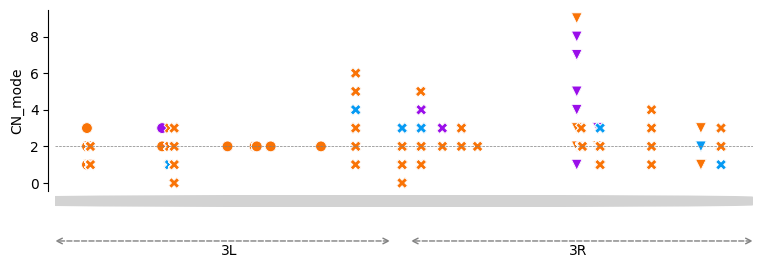

In [59]:
fig = plt.figure(figsize=(9,3))
gs = plt.GridSpec(nrows=3, ncols=1, height_ratios=(6,0.4,1),hspace=0.05)
ax0 = fig.add_subplot(gs[0])
sns.despine(ax=ax0, bottom=True, top = True, offset=5)
sns.scatterplot(x='pos_3RL', y='CN_mode', hue='aim_species', data=cnv_3RL, markers=g_marker,style='gene_map',
                palette=color, s=60, legend=False, ax=ax0)

ax0.set_xlabel('')
plt.xticks(ticks=[], labels=[])
plt.axhline(y=2,ls='--',lw=0.5, c='gray')

ax1 = plt.subplot(gs[1,0])
fig_seq(pos_3RL,xy=(0,0), wh=(pos_3RL[-1],0.05),boxstyle=("Round4, pad=0.1"), ax=ax1,
        facecolor='lightgray', edgecolor='lightgray')
plt.xticks(ticks=[], labels=[])

ax2 = fig.add_subplot(gs[2, 0])
#sns.despine(ax=ax2, bottom=True, left=True)
ax2.text(0.25, -0.1, '3L', va='top', ha='center', fontsize=10)
ax2.text(0.75, -0.1, '3R', va='top', ha='center', fontsize=10)

ax2.annotate("", xy=(0, 0), xytext=(0.48, 0),
             arrowprops=dict(arrowstyle="<->", linestyle='--',shrinkA= 0, shrinkB= 0, lw=1, color='gray'))

ax2.annotate("", xy=(0.51, 0), xytext=(1, 0),
             arrowprops=dict(arrowstyle="<->", linestyle='--',shrinkA= 0, shrinkB= 0, lw=1, color='gray'))

plt.axis('off')

In [60]:
## TODO
#set fig xlim - use the limit of each arm
# plot a big graphic for all
#